Loading Household Member Data (Analyzing ITN Use)...


/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_4811/707376178.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['w'] = df['hv005'] / 1000000.0


Analyzing 55287 de facto household members.

--- Summary Results: Population Sleeping under ITN (%) ---
                   Slept under ITN %
Location                            
Rwamagana                         37
Nyagatare                         46
Gatsibo                           32
Kayonza                           26
Kirehe                            53
Ngoma                             67
Bugesera                          30
East Province                     41
Rwanda (National)                 48
✅ Success! JSON: eastern_itn_use_population.json, Plot: ITN_Use_Population.png


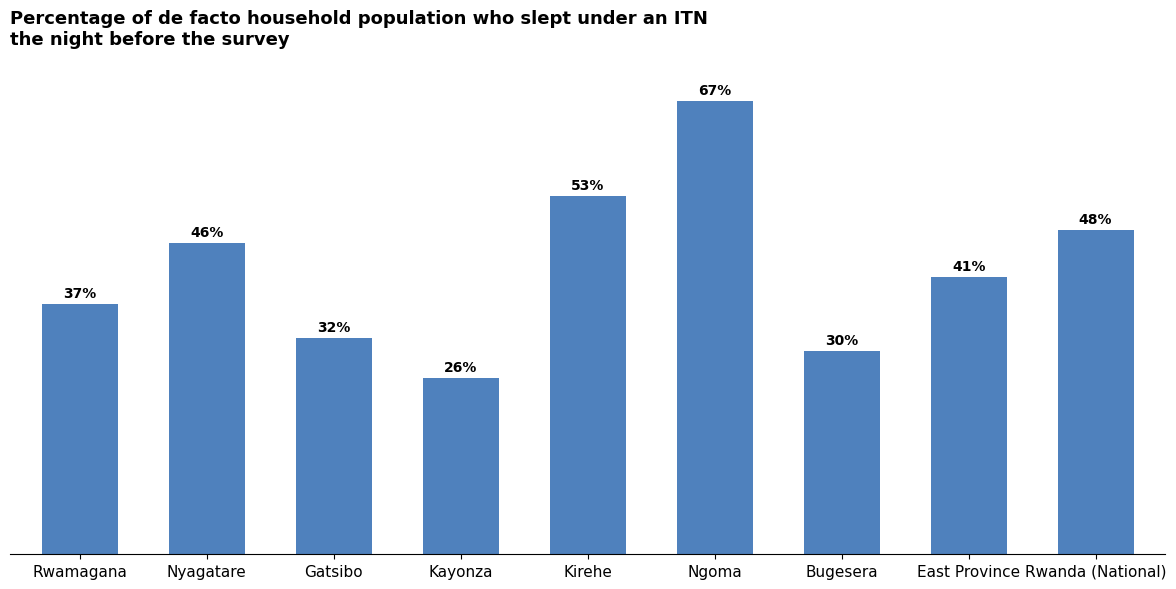

In [1]:
#!/usr/bin/env python3
# dhs_malaria_itn_use_pop.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
# PR file is the standard for household population indicators
FILE_PATH = os.path.join(DATA_DIR, "RWPR81FL.DTA")

DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    """RDHS Rounding: 0.5 becomes 1."""
    return int(math.floor(n + 0.5))

def get_itn_stats(df):
    """Calculates weighted % of de facto population sleeping under an ITN."""
    if df.empty or 'w' not in df.columns or df['w'].sum() == 0:
        return 0
    
    # hml12: Slept under an ITN last night (1 = Yes)
    # We only care about code 1
    raw_pct = np.average(df['hml12'] == 1, weights=df['w']) * 100
    return standard_round(raw_pct)

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Household Member Data (Analyzing ITN Use)...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- FORCED NUMERIC CONVERSION ---
    # hml12: Slept under ITN | hv103: Slept in house | hv005: weight
    cols_to_fix = ['hv005', 'hv024', 'shdistrict', 'hml12', 'hv103']
    for col in cols_to_fix:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Weights
    df['w'] = df['hv005'] / 1000000.0

    # --- ACCURACY FILTERS ---
    # 1. De Facto Population (Only those who slept in the house last night)
    df_defacto = df[df['hv103'] == 1].copy()
    
    print(f"Analyzing {len(df_defacto)} de facto household members.")

    # --- AGGREGATION ---
    results = {}
    dist_col = 'shdistrict' if 'shdistrict' in df.columns else 'hv001'
    
    # Filter Eastern Province (Region 5)
    df_east = df_defacto[df_defacto['hv024'] == 5].copy()
    
    for code, name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == code]
        results[name] = get_itn_stats(subset)

    # Totals
    results["East Province"] = get_itn_stats(df_east)
    results["Rwanda (National)"] = get_itn_stats(df_defacto)

    final_df = pd.DataFrame(list(results.items()), columns=["Location", "Slept under ITN %"]).set_index("Location")
    print("\n--- Summary Results: Population Sleeping under ITN (%) ---")
    print(final_df)

    # --- JSON OUTPUT ---
    json_name = "eastern_itn_use_population.json"
    with open(json_name, "w") as f:
        json.dump(final_df["Slept under ITN %"].to_dict(), f, indent=4)

    # --- PLOTTING ---
    # Colors: Blue for Districts, Green for Province, Orange for Rwanda
    colors = ["#4F81BD"] * 7 + ["#00B050", "#ED7D31"]
    ax = final_df.plot(kind="bar", color=colors, figsize=(12, 6), width=0.6, legend=False)
    
    plt.title("Percentage of de facto household population who slept under an ITN\nthe night before the survey", 
              fontsize=13, fontweight='bold', loc='left', pad=25)
    
    plt.xticks(rotation=0, fontsize=11)
    plt.xlabel("")
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: ax.spines[s].set_visible(False)
    
    # Add labels on top of bars
    for c in ax.containers:
        ax.bar_label(c, fmt='%d%%', padding=3, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig("ITN_Use_Population.png", dpi=300)
    print(f"✅ Success! JSON: {json_name}, Plot: ITN_Use_Population.png")